# Importing Libraries

In [107]:

import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
init_notebook_mode(connected=True)

#keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

RANDOM_SEED = 123

# Train Test Splitting

In [108]:
# Creating folders for Training,Testing and Validation.
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO

mkdir: TRAIN: File exists
mkdir: TEST: File exists
mkdir: VAL: File exists
mkdir: TRAIN/YES: File exists
mkdir: TRAIN/NO: File exists
mkdir: TEST/YES: File exists
mkdir: TEST/NO: File exists
mkdir: VAL/YES: File exists
mkdir: VAL/NO: File exists


In [109]:
img_path = '/Users/lokesh/Desktop/ds/Deep Learning/codes/braintumor detection/dataset/'
# spliting the data by train/val/test
for class_name in os.listdir(img_path):
    if not class_name.startswith('.'):
        images = len(os.listdir(img_path + class_name))
        for (n, file_name) in enumerate(os.listdir(img_path + class_name)):
            img = img_path + class_name + '/' + file_name
            if n < 5:
                shutil.copy(img, 'TEST/' + class_name.upper() + '/' + file_name)
            elif n < 0.8 * images:
                shutil.copy(img, 'TRAIN/' + class_name.upper() + '/' + file_name)
            else:
                shutil.copy(img, 'VAL/' + class_name.upper() + '/' + file_name)

# Data Preprocessing



In [110]:
# Loading images as Numpy arrays
def load_data(dir_path, img_size=(100,100)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img =cv2.resize(img,(224,224))
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()  
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [111]:
train_dir = 'TRAIN/'
test_dir = 'TEST/'
val_dir = 'VAL/'
img_size =(224,224)


X_train, y_train, labels = load_data(train_dir, img_size)
X_test, y_test, _ = load_data(test_dir, img_size)
X_val, y_val, _ = load_data(val_dir, img_size)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 12.32it/s]


193 images loaded from TRAIN/ directory.


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 236.50it/s]


10 images loaded from TEST/ directory.


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 55.05it/s]

50 images loaded from VAL/ directory.


Distribution of Yes/No among sets

{0: [74, 19, 5], 1: [119, 31, 5]}


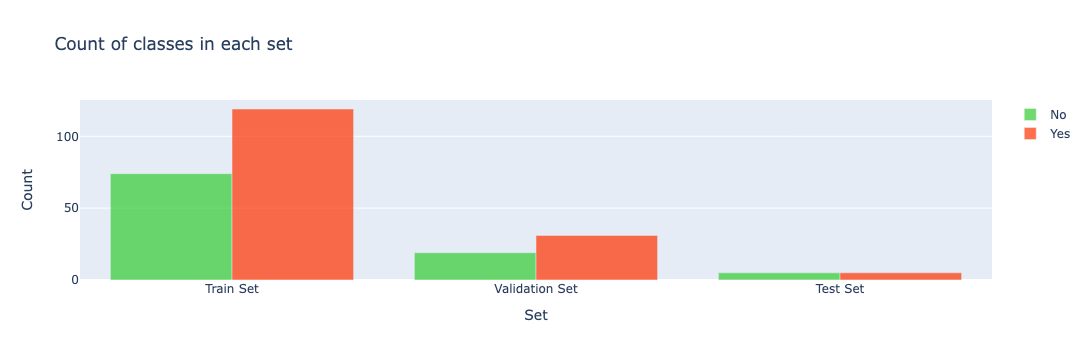

In [112]:
print(y)
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [113]:
def plot_samples(X, y, labels_dict, n=50):
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

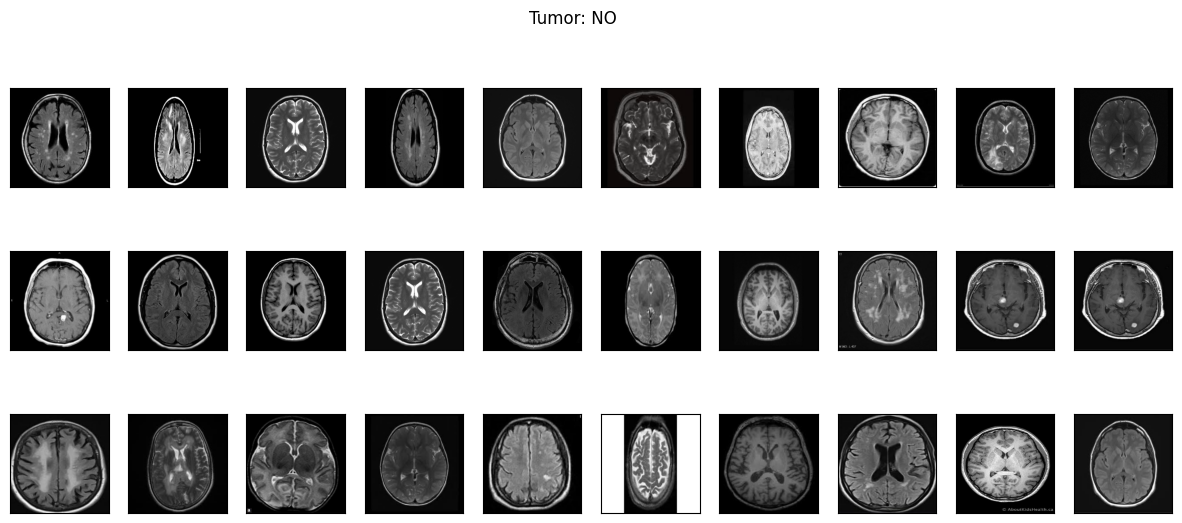

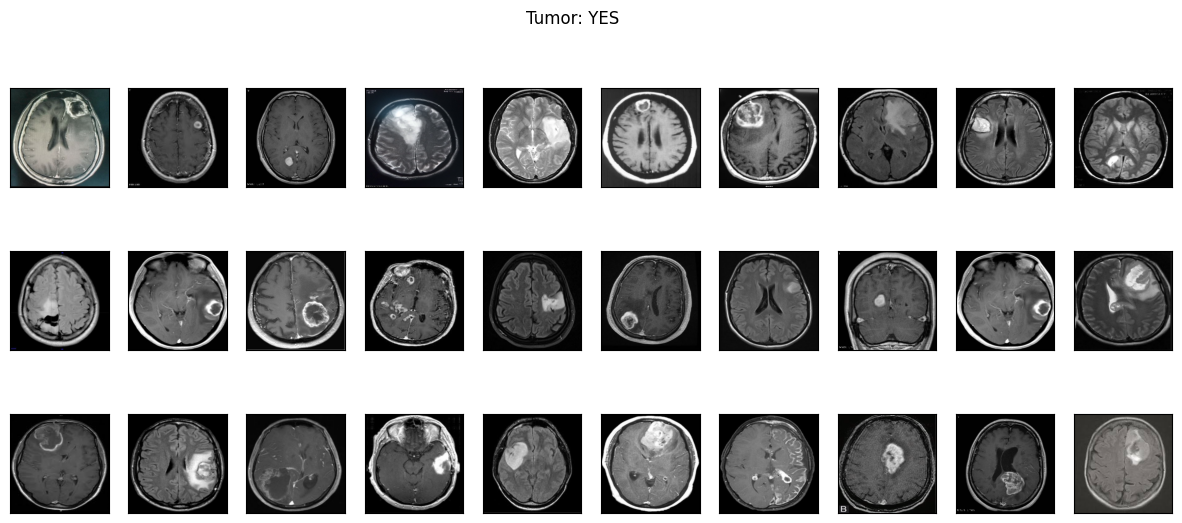

In [114]:
plot_samples(X_train, y_train, labels, 30)

Cropping the image

In [115]:
def crop_imgs(set_name, add_pixels_value=0,target_size=(244,244)):
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        #Threshold
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # contours
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(new_img, target_size)
        set_new.append(new_img)

    return np.array(set_new)

In [116]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

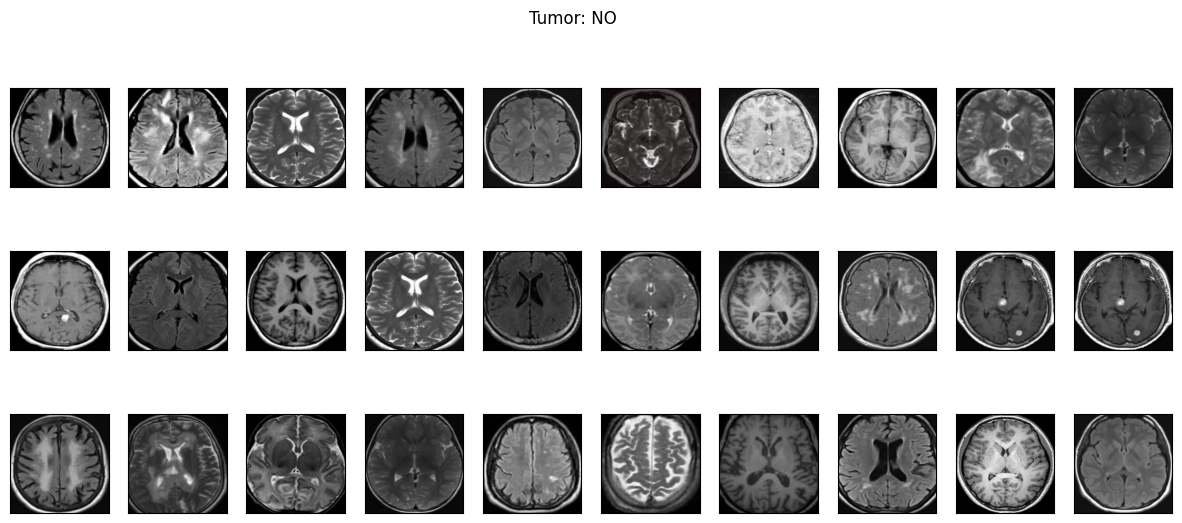

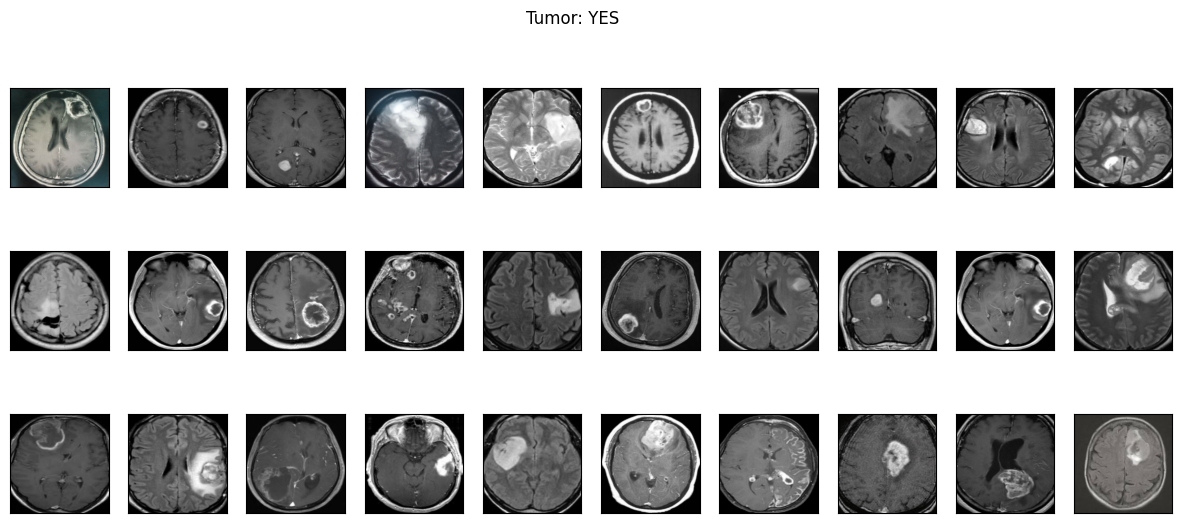

In [117]:
plot_samples(X_train_crop, y_train, labels, 30)

In [118]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [119]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: TRAIN_CROP: File exists
mkdir: TEST_CROP: File exists
mkdir: VAL_CROP: File exists
mkdir: TRAIN_CROP/YES: File exists
mkdir: TRAIN_CROP/NO: File exists
mkdir: TEST_CROP/YES: File exists
mkdir: TEST_CROP/NO: File exists
mkdir: VAL_CROP/YES: File exists
mkdir: VAL_CROP/NO: File exists


In [120]:
X_train_crop.shape

(193, 244, 244, 3)

# Data Augmentation

In [121]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=img_size,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


# CNN Model

In [122]:
base_model = VGG16(
    weights="imagenet",
    include_top=False, 
    input_shape=img_size + (3,)
)

In [123]:
#binary 
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [124]:
history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
7/7 [==============================] - 61s 10s/step - loss: 11.7041 - accuracy: 0.6166 - val_loss: 2.1209 - val_accuracy: 0.7400
Epoch 2/30
7/7 [==============================] - 68s 10s/step - loss: 5.9033 - accuracy: 0.6269 - val_loss: 3.1749 - val_accuracy: 0.7200
Epoch 3/30
7/7 [==============================] - 63s 9s/step - loss: 2.9000 - accuracy: 0.7409 - val_loss: 5.6856 - val_accuracy: 0.6200
Epoch 4/30
7/7 [==============================] - 64s 9s/step - loss: 2.1822 - accuracy: 0.7876 - val_loss: 7.2445 - val_accuracy: 0.5200
Epoch 5/30
7/7 [==============================] - 60s 9s/step - loss: 4.9651 - accuracy: 0.6995 - val_loss: 3.5326 - val_accuracy: 0.7000
Epoch 6/30
7/7 [==============================] - 62s 9s/step - loss: 2.1189 - accuracy: 0.7876 - val_loss: 3.2039 - val_accuracy: 0.9000
Epoch 7/30
7/7 [==============================] - 58s 8s/step - loss: 3.3269 - accuracy: 0.7927 - val_loss: 2.8911 - val_accuracy: 0.8400
Epoch 8/30
7/7 [===============

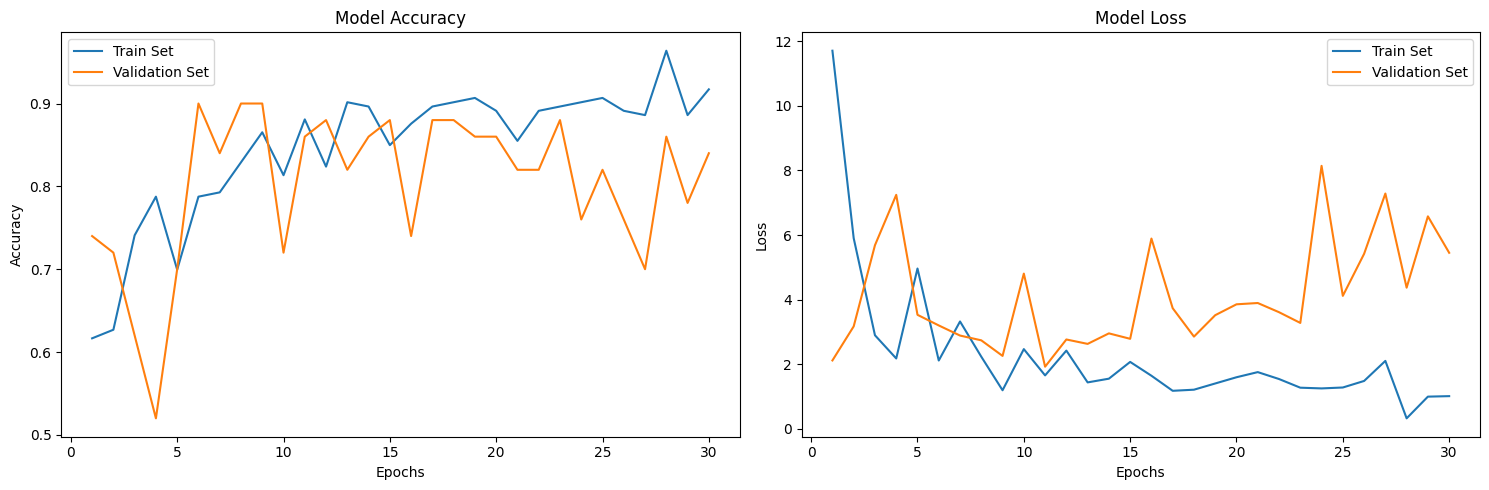

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

# Plot model performance
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

2/2 [==============================] - 1031s 1023s/step
Validation Accuracy = 0.80
1/1 [==============================] - 2s 2s/step
Test Accuracy = 0.80


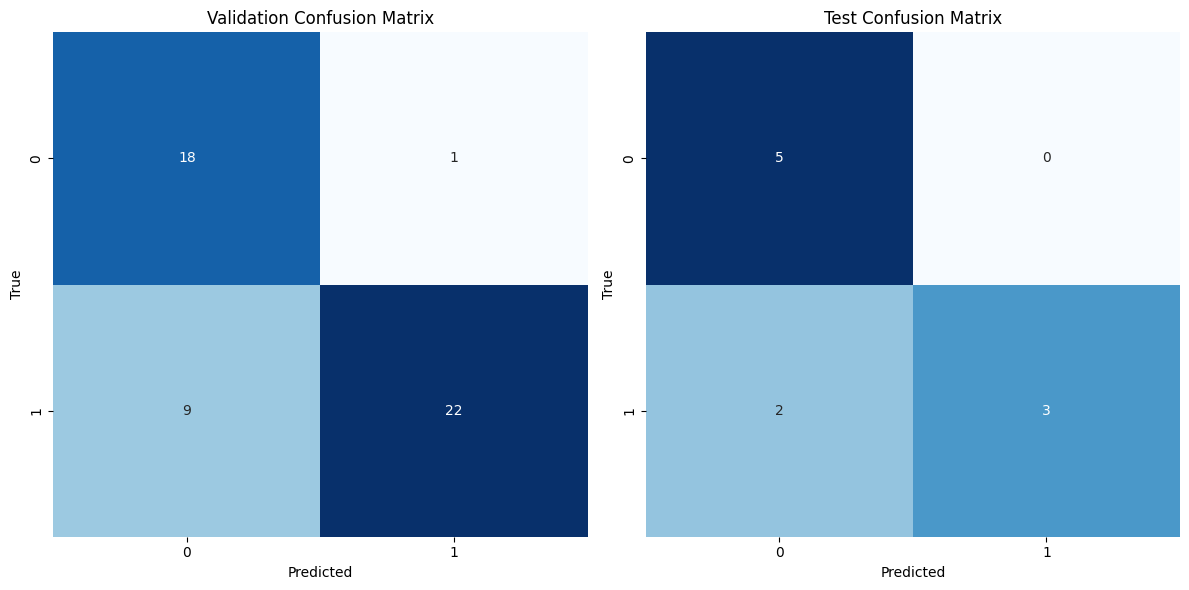

In [126]:
# Validation Set
resized_images = [cv2.resize(img, (224, 224)) for img in X_val_crop]
X_val_resized = np.array(resized_images)
predictions_val = model.predict(X_val_resized)
predictions_val = [1 if x > 0.5 else 0 for x in predictions_val]

accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation Accuracy = %.2f' % accuracy_val)
confusion_mtx_val = confusion_matrix(y_val, predictions_val)

# Test Set
resized_images_test = [cv2.resize(img, (224, 224)) for img in X_test_crop]
X_test_resized = np.array(resized_images_test)
predictions_test = model.predict(X_test_resized)
predictions_test = [1 if x > 0.5 else 0 for x in predictions_test]

accuracy_test = accuracy_score(y_test, predictions_test)
print('Test Accuracy = %.2f' % accuracy_test)
confusion_mtx_test = confusion_matrix(y_test, predictions_test)


# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Validation Confusion Matrix
sns.heatmap(confusion_mtx_val, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Validation Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Test Confusion Matrix
sns.heatmap(confusion_mtx_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

# Wrong Predictions

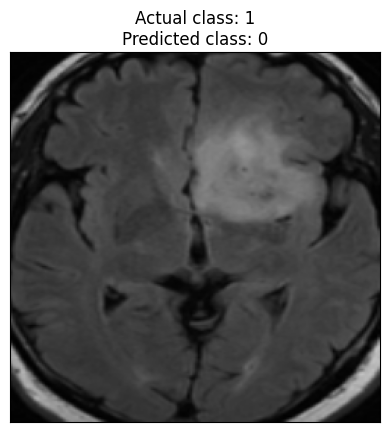

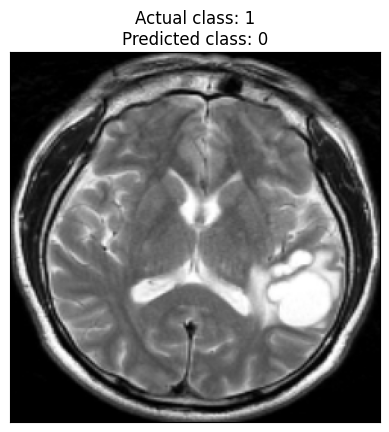

In [127]:
ind_list = np.argwhere((y_test == predictions_test) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions_test[i]}')
        plt.show()